In [7]:
from PIL import Image
import scipy as sp
import torch
import numpy as np
import skimage.graph
from skimage.util import map_array
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [37]:
SIGMA = 0.3

""" Image Preprocessing
Our goal here is to create the affinity matrix.
"""
# Load the image
image = Image.open('/content/test_image4.jpg').convert('RGB')
image_array = np.array(image)
height, width, _ = image_array.shape

# Flatten the pixels
flat_image_array = image_array.reshape(-1, 3)

# Normalize the pixels
flat_image_array = flat_image_array / 256

# We now enter the complicated part.
"""
mask is a boolean array of the size same as the image.
Elements are all True.
Example:
image = [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]
Then
mask = [[True, True, True],
        [True, True, True],
        [True, True, True]]
"""
mask = np.ones((height, width)).astype(bool)

"""
padded is another boolean array which adds the padding of False to mask.

Example:
mask = [[True, True, True],
        [True, True, True],
        [True, True, True]]
padded = [[False, False, False, False, False],
          [False, True, True, True, False],
          [False, True, True, True, False],
          [False, True, True, True, False],
          [False, False, False, False, False]]
"""
padded = np.pad(mask, 1, mode='constant', constant_values=False)
height_padded, width_padded = padded.shape

"""
nodes_padded is an array of indices of the pixels having True in padded.
Indices are flattened and also in the padded space.

Example:
padded = [[False, False, False, False, False],
          [False, True, True, True, False],
          [False, True, True, True, False],
          [False, True, True, True, False],
          [False, False, False, False, False]]
nodes_padded = [6, 7, 8, 11, 12, 13, 16, 17, 18]
"""
nodes_padded = np.flatnonzero(padded)

"""
neighbor_offsets_padded is an array of offsets to get the indices of the neighbors.
The following means that if we add the following numbers to the indices in nodes_padded,
we get the indices of the neighbors in the padded space.
"""
neighbor_offsets_padded = np.array([1, -1, -width_padded, width_padded])

"""
negihbors_padded is an array of indices of the neighbors.
The i,j element of it is the index in the padded space of the jth neighbor of
the ith valid pixel (valid means having True value in padded)

We note that not all neighbors are valid, so we need to remove those values
later.

Example:
padded = [[False, False, False, False, False],
          [False, True, True, True, False],
          [False, True, True, True, False],
          [False, True, True, True, False],
          [False, False, False, False, False]]
nodes_padded = [6, 7, 8, 11, 12, 13, 16, 17, 18]
neighbors_padded = [[ 7  5  1 11]
 [ 8  6  2 12]
 [ 9  7  3 13]
 [12 10  6 16]
 [13 11  7 17]
 [14 12  8 18]
 [17 15 11 21]
 [18 16 12 22]
 [19 17 13 23]]
"""
neighbors_padded = nodes_padded[:, np.newaxis] + neighbor_offsets_padded

"""
nodes is an array of index in the original image space.
nodes = [0, 1, 2, ..., #pixels-1].
"""
nodes = np.flatnonzero(mask)

"""
For neighbors_padded, we map the indices in the padded space to the indices in
the original image space.
If the indexes are out of bounds, we set them to 0.

Example:
neighbors_padded = [[ 7  5  1 11]
 [ 8  6  2 12]
 [ 9  7  3 13]
 [12 10  6 16]
 [13 11  7 17]
 [14 12  8 18]
 [17 15 11 21]
 [18 16 12 22]
 [19 17 13 23]]
 Then
 neighbors = [[1 0 0 3]
 [2 0 0 4]
 [0 1 0 5]
 [4 0 0 6]
 [5 3 1 7]
 [0 4 2 8]
 [7 0 3 0]
 [8 6 4 0]
 [0 7 5 0]]
"""
neighbors = map_array(neighbors_padded, nodes_padded, nodes)

"""
To remove the invalid neighbors, we prepare a boolean mask.
it tells you which indexes in neighbors are valid.

Example:
neighbors_padded = [[ 7  5  1 11]
 [ 8  6  2 12]
 [ 9  7  3 13]
 [12 10  6 16]
 [13 11  7 17]
 [14 12  8 18]
 [17 15 11 21]
 [18 16 12 22]
 [19 17 13 23]]
Then
[[ True False False  True]
 [ True  True False  True]
 [False  True False  True]
 [ True False  True  True]
 [ True  True  True  True]
 [False  True  True  True]
 [ True False  True False]
 [ True  True  True False]
 [False  True  True False]]


Here, we are using so-called "advanced indexing" to do this.
If we have an array X and another integer array Y (not necessarily of the same
shape), then X[Y] would be of the same shape as Y, and each element y of Y would
be replaced by X[y].
"""
neighbors_mask = padded.reshape(-1)[neighbors_padded]

"""
We calculate the number of valid neighbors for each node.
In the above example,
num_neighbors = [2, 3, 2, 3, 4, 3, 2, 3, 2]
"""
num_neighbors = np.sum(neighbors_mask, axis=1)

"""
We repeat indices for the number of neighbors.
In the above example,
indices = [0 0 1 1 1 2 2 3 3 3 4 4 4 4 5 5 5 6 6 7 7 7 8 8]

This will be the "row" part of the adjacency matrix in the COO format.
"""
indices = np.repeat(nodes, num_neighbors)

"""
We find the flattened array of indices of neighbors.
It has the format
(neighbor #1 of node 1),...,(neighbor #num_neigbors of node 1),
(neighbor #1 of node 2),...,(neighbor #num_neigbors of node 2),
...
In the above example,
neighbor_indices=
[1 3 |2 0 4| 1 5| 4 0 6| 5 3 1 7| 4 2 8| 7 3| 8 6 4| 7 5]
I added | so that we can see which part corresponds to each node.
Obviously, it wouldn't appear in the real result.

It is the "column" part of the adjacency matrix in COO format.

We are using so-called "boolean masking" to do this.
If we have an array X  and another boolean array Y of the same shape,
X[Y] would be a 1D array collecting all elements in X having True in Y.
"""
neighbor_indices = neighbors[neighbors_mask]

"""
We now calculate the data part of the adjacency matrix in COO format.
"""
data = np.exp(-np.linalg.norm(flat_image_array[indices]- \
          flat_image_array[neighbor_indices], axis = 1)**2/SIGMA**2)

"""
Finally, construct the adjacency matrix in COO format and convert it into CSR.
"""
mat_coo = sp.sparse.coo_matrix(
        (data, (indices, neighbor_indices)),
        shape=(nodes.size, nodes.size)
        )
adjacency_matrix = mat_coo.tocsr()

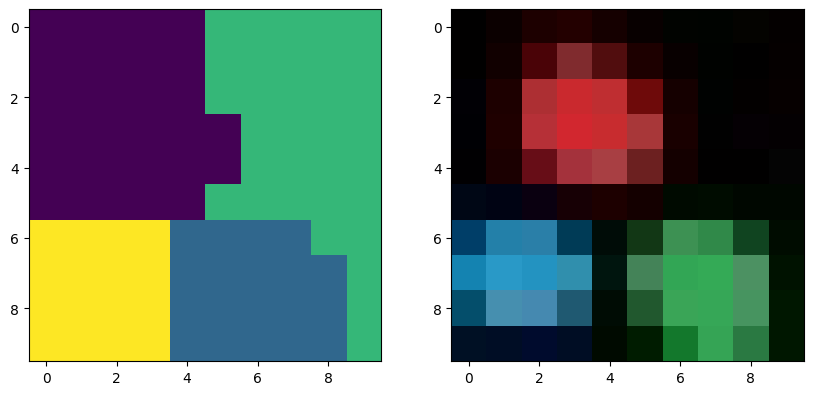

In [38]:
"""
Spectral Clustering
"""

# Create a spectral clustering object
spec = SpectralClustering(n_clusters=4, affinity='precomputed')

# Perform spectral clustering
spec.fit(adjacency_matrix)

# Construct label image
label_image = spec.labels_.reshape(height, width)

# Display the label image and the original image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(label_image)
plt.subplot(1, 2, 2)
plt.imshow(image)

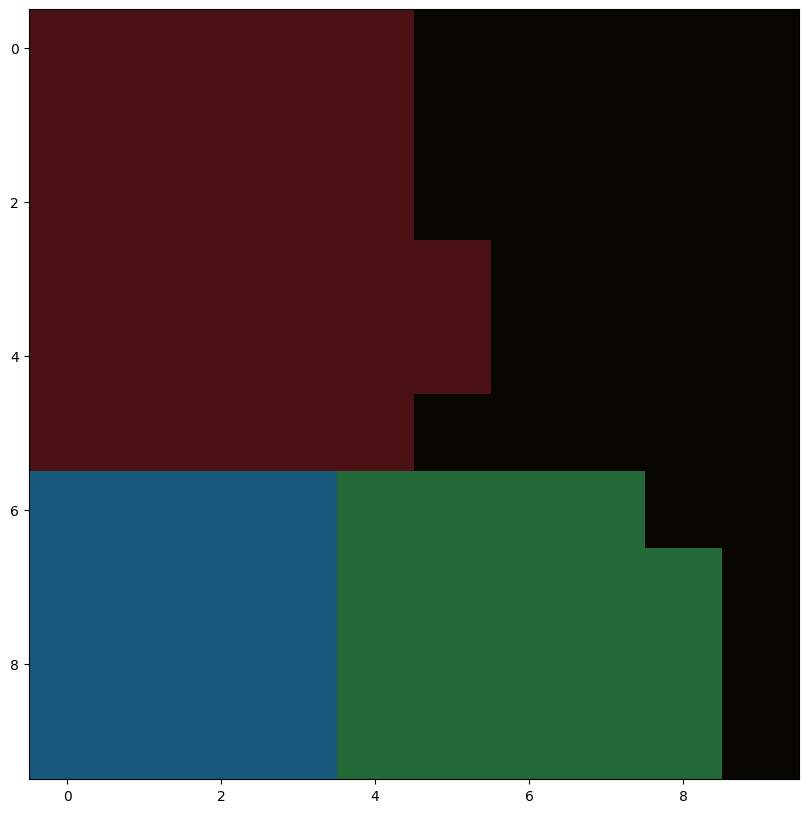

In [51]:
"""
Construction of mean color figure
"""
flat_mean_color_image = np.zeros((width*height, 3))

# Loop over all clusters
for cluster_label in np.unique(spec.labels_):
  indices = np.where(spec.labels_ == cluster_label)
  mean_color = np.mean(flat_image_array[indices], axis=0)
  flat_mean_color_image[indices] = mean_color

# Display the mean color image
plt.figure(figsize=(10, 10))
plt.imshow(flat_mean_color_image.reshape(height, width, 3))